In [1]:
# Hyperparams
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS =20
BATCH_SIZE =30
TEST_SIZE = 2
learning = 0.0001
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [2]:
import keras
from keras import layers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKeras

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf

In [4]:
#xception - Pretrained

import keras
from classification_models.keras import Classifiers

xception, preprocess_input = Classifiers.get('xception')
%matplotlib inline

base_x=xception(input_shape=(224,224,3), weights='imagenet', include_top=False)
x3 = keras.layers.GlobalAveragePooling2D()(base_x.output)
output_x = keras.layers.Dense(2, activation='softmax')(x3)
model_x = keras.models.Model(inputs=[base_x.input], outputs=[output_x])

model_x.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])


import warnings
warnings.filterwarnings("ignore")


In [5]:
# with open(MODEL_SUMMARY_FILE2,"w") as fh:
#     model.summary(print_fn=lambda line: fh.write(line + "\n"))

training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [6]:
cd"dataset3"

/mnt/batch/tasks/shared/LS_root/mounts/clusters/machine-le-ins5/code/dataset3


In [7]:
# 
training_data_dir ="train" # 
validation_data_dir = "test" #

In [8]:
# from keras.models import load_model
# hybrid=load_model("Xception.h5")

In [9]:
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False)

Found 1003 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [10]:
TRAINING_LOGS_FILE2 = "training_logs11.csv"

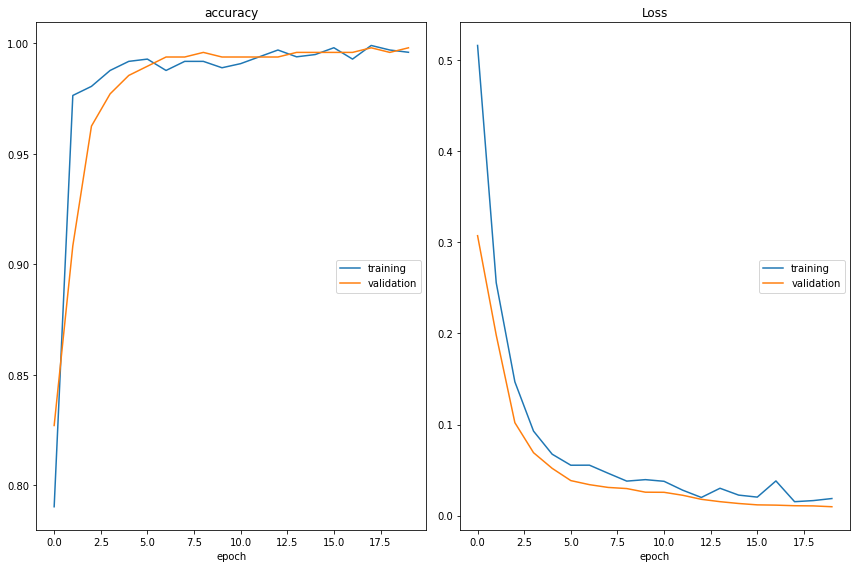

accuracy
	training         	 (min:    0.790, max:    0.999, cur:    0.996)
	validation       	 (min:    0.827, max:    0.998, cur:    0.998)
Loss
	training         	 (min:    0.015, max:    0.516, cur:    0.019)
	validation       	 (min:    0.010, max:    0.307, cur:    0.010)
33/33 [==============================] - 424s 13s/step - loss: 0.0188 - accuracy: 0.9959 - val_loss: 0.0098 - val_accuracy: 0.9979
CPU times: user 5h 41min 47s, sys: 13min 38s, total: 5h 55min 26s
Wall time: 1h 46min 44s


In [11]:
%%time
import warnings
warnings.filterwarnings("ignore")

# Training
H = model_x.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[PlotLossesKeras(), CSVLogger(TRAINING_LOGS_FILE2,
                                            append=False,
                                            separator=";")], 
    verbose=1)

#model_x.save_weights(model_x_FILE2)

In [ ]:
#modelx_FILE="model_x.h5"

In [ ]:
#model_x.save_weights(modelx_FILE)

In [ ]:
N = EPOCHS
plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

LABELS = ["covid-19","normal"]

def show_confusion_matrix(validations, predictions):
    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False)    

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model_x.predict_generator(validation_generator,(nb_samples//BATCH_SIZE))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
show_confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ["covid-19","normal"]
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
   fpr[i], tpr[i], _ = roc_curve(validation_generator.classes, y_pred)
   roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
       lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model_x.save('Xception.h5')

In [ ]:
from tf_keras_vis.scorecam import ScoreCAM